## Diseno

In [2]:
import numpy as np
import gymnasium as gym
from multiprocessing import Pool
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)

In [4]:
class Perceptron:
    def __init__(self, ninput, noutput):
        self.ninput = ninput
        self.noutput = noutput
        self.w = np.random.rand(ninput, noutput) - 0.5
        self.b = np.random.rand(noutput) - 0.5

    def forward(self, x):
        u = np.dot(x, self.w) + self.b
        return np.piecewise(u, [u < 0, u >= 0], [0, 1])

    def from_chromosome(self, chromosome):
        w_size = self.ninput * self.noutput
        self.w = np.array(chromosome[:w_size]).reshape(self.ninput, self.noutput)
        self.b = np.array(chromosome[w_size:w_size + self.noutput])

In [5]:
def fitness(chromosome):
    env = gym.make("LunarLander-v3", render_mode=None)
    model = Perceptron(8, 4)
    model.from_chromosome(chromosome)
    total_reward = 0

    for _ in range(5):  # Generalization with multiple episodes
        observation, _ = env.reset()
        episode_reward = 0
        while True:
            action = np.argmax(model.forward(observation))
            observation, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            if terminated or truncated:
                break
        total_reward += episode_reward

    env.close()
    return total_reward / 5

In [6]:
# Parallelized Fitness Evaluation
def evaluate_population(population):
    fitness_values = []
    for chromosome in population:
        fitness_values.append(fitness(chromosome))
    return np.array(fitness_values)

In [7]:
# Initialize Population
def initialize_population(population_size, chromosome_size):
    return np.random.uniform(-3, 3, (population_size, chromosome_size))

In [8]:
# Tournament Selection
def tournament_selection(population, fitness_values, k=5):
    selected = []
    for _ in range(len(population)):
        indices = np.random.choice(len(population), k, replace=False)
        best = indices[np.argmax([fitness_values[i] for i in indices])]
        selected.append(population[best])
    return np.array(selected)

In [9]:
# Roulette Wheel Selection
def roulette_wheel_selection(population, fitness_values, population_size, num_elites=15):
    # Elitismo: selecciona los mejores individuos directamente
    elite_indices = np.argsort(fitness_values)[-num_elites:]
    elites = [population[i] for i in elite_indices]

    # Normaliza los valores de fitness para obtener probabilidades
    total_fitness = sum(fitness_values)
    probabilities = fitness_values / total_fitness

    # Distribuye los marcadores en la ruleta
    cumulative_probabilities = np.cumsum(probabilities)
    markers = np.linspace(0, 1, population_size - num_elites, endpoint=False) + np.random.uniform(0, 1 / (population_size - num_elites))

    # Selecciona individuos segun los marcadores
    selected = []
    for marker in markers:
        for i, cp in enumerate(cumulative_probabilities):
            if marker <= cp:
                selected.append(population[i])
                break

    # Combina los elites y los seleccionados
    return elites + selected

In [10]:
# Plain Operator
def plain_operator(parent1, parent2):
    parent1 = np.array(parent1)
    parent2 = np.array(parent2) 
    
    child1 = np.zeros_like(parent1)
    child2 = np.zeros_like(parent2)

    for i in range(len(parent1)):
        min_val = min(parent1[i], parent2[i])
        max_val = max(parent1[i], parent2[i])
        child1[i] = np.random.uniform(min_val, max_val)
        child2[i] = min_val + max_val - child1[i]

    return child1, child2

In [11]:
# BLX-α Crossover
def blx_alpha_crossover(parent1, parent2, alpha=0.5):
    parent1 = np.array(parent1)
    parent2 = np.array(parent2)
    
    child1 = np.zeros_like(parent1)
    child2 = np.zeros_like(parent2)

    for i in range(len(parent1)):
        d = abs(parent1[i] - parent2[i])
        min_val = min(parent1[i], parent2[i]) - alpha * d
        max_val = max(parent1[i], parent2[i]) + alpha * d
        child1[i] = np.random.uniform(min_val, max_val)
        child2[i] = min_val + max_val - child1[i]

    return child1, child2

In [12]:
# Formula utilizada en Morfologico
def phi(gi, a=-0.001, b=-0.133, c=0.54, d=0.226):
    if gi == 0:
        return a
    elif gi < c:
        # Linear interpolation between (0, a) and (c, b)
        return a + (b - a) * (gi / c)
    elif gi == c:
        return 0
    elif gi < 1:
        # Linear interpolation between (c, 0) and (1, d)
        return 0 + (d - 0) * ((gi - c) / (1 - c))
    elif gi == 1:
        return d
    else:
        raise ValueError("g_i must be in the range [0, 1].")

In [13]:
# Morphological Crossover
def morphological_crossover(population):
    child1 = np.zeros_like(population[0])
    child2 = np.zeros_like(population[0])

    norm_population = (population - np.min(population)) / (np.max(population) - np.min(population))

    for i in range(len(population[0])):
        gene_values = [ind[i] for ind in norm_population]
        #print(gene_values)

        diversity = max(gene_values) - min(gene_values)
        #print(diversity)
        phi_value = phi(diversity)
        min_val = min(gene_values) + phi_value
        max_val = max(gene_values) - phi_value

        child1[i] = np.random.uniform(min_val, max_val)
        child2[i] = min_val + max_val - child1[i]
 
    child1 = child1 * (np.max(population) - np.min(population)) + np.min(population)
    child2 = child2 * (np.max(population) - np.min(population)) + np.min(population)

    return child1, child2

In [14]:
# Mutation
def mutate(chromosome, mutation_rate=0.1):
    for i in range(len(chromosome)):
        if np.random.rand() < mutation_rate:
            chromosome[i] += np.random.uniform(-0.5, 0.5)
    return chromosome

In [15]:
# Genetic Algorithm Main Loop
def genetic_algorithm(name, population_size=100, chromosome_size=36, generations=50, mutation_rate=0, elitism=True, crossover='single_point',alpha=0.5,k=5, e = 15 ,selection_method = 'tournament'):
    population = initialize_population(population_size, chromosome_size)
    print(population[0])
    
    print("Population Initialized")
    best_fitness_per_generation = []
    mean_fitness_per_generation = []
    median_fitness_per_generation = []

    for generation in range(generations):
        # Evaluate Fitness
        fitness_values = evaluate_population(population)
        best_fitness_per_generation.append(np.max(fitness_values))
        mean_fitness_per_generation.append(np.mean(fitness_values))
        median_fitness_per_generation.append(np.median(fitness_values))

        print(f"Generation {generation + 1}, Best Fitness: {np.max(fitness_values)}")

        # Selection
        if selection_method == 'tournament':
            selected = tournament_selection(population, fitness_values,k)
        elif selection_method == 'roulette':
            selected = roulette_wheel_selection(population, fitness_values,population_size, num_elites = e)
        

        # Crossover and Mutation
        new_population = []
        for i in range(0, len(selected), 2):
            parent1, parent2 = selected[i], selected[i + 1]

            # codificacion real
            if crossover == 'plain':
                child1, child2 = plain_operator(parent1, parent2)
            elif crossover == 'blx_alpha':
                child1, child2 = blx_alpha_crossover(parent1, parent2,alpha)
            elif crossover == 'morphological':
                if i + 7 > len(selected):
                    selected2 = np.concatenate((selected[i:], selected[:7 - (len(selected) - i)]))
                else:
                    selected2 = selected[i:i+7]
                child1, child2 = morphological_crossover(selected2)

            new_population.append(mutate(child1, mutation_rate))
            new_population.append(mutate(child2, mutation_rate))

        # Apply Elitism
        if elitism:
            best_index = np.argmax(fitness_values)
            new_population[0] = population[best_index]

        population = np.array(new_population)

    # Saving fitness evolution
    np.save("best"+str(name)+".npy", best_fitness_per_generation)
    np.save("mean"+str(name)+".npy", mean_fitness_per_generation)
    np.save("median"+str(name)+".npy", median_fitness_per_generation)

    # Return the best chromosome
    np.save("best_chromosome"+str(name)+".npy", population[np.argmax(evaluate_population(population))])
    return population[np.argmax(evaluate_population(population))]

In [16]:
import numpy as np
from statistics import mean, stdev

def evaluate_best_chromosome(
    chromosome,
    runs: int = 100,
    seeds: list[int] = None
) -> dict:
    """
    Evalúa un cromosoma fijo en LunarLander durante 'runs' episodios,
    usando distintas semillas si se proporcionan.

    Devuelve un dict con:
      - 'rewards': lista de recompensas por episodio
      - 'mean': media de recompensas
      - 'std': desviación estándar
      - 'ci95': intervalo de confianza 95% (±)
    """
    # Preparar seeds
    if seeds is None:
        # 100 semillas distintas
        seeds = list(range(runs))
    else:
        # en caso de pasar menos semillas que runs
        seeds = (seeds * ((runs // len(seeds)) + 1))[:runs]

    env = gym.make("LunarLander-v3", render_mode="human")
    model = Perceptron(8, 4)
    model.from_chromosome(chromosome)

    rewards = []
    for run_idx in range(runs):
        # reproducibilidad
        seed = seeds[run_idx]
        np.random.seed(seed)
        observation, _ = env.reset(seed=seed)
        episode_reward = 0

        done = False
        while not done:
            action = np.argmax(model.forward(observation))
            observation, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            done = terminated or truncated

        rewards.append(episode_reward)
        print(f"Run {run_idx+1}/{runs} (seed={seed}): Reward = {episode_reward}")

    env.close()

    # Cálculos estadísticos
    μ = mean(rewards)
    σ = stdev(rewards)
    se = σ / np.sqrt(runs)
    ic95 = 1.96 * se

    print(f"\n  Resultados despues de  {runs} simulaciones:")
    print(f"  Recompensa Media    : {μ:.2f}")
    print(f"  Desviacion Tipica      : {σ:.2f}")
    print(f"  Inter. de conf. 95%      : ±{ic95:.2f}")

    return {
        "rewards": rewards,
        "mean": μ,
        "std": σ,
        "ci95": ic95
    }


In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_rewards(rewards):
    """
    Dibuja una gráfica de serie temporal de las recompensas de cada simulación,
    incluyendo una línea punteada con la recompensa media y muestre la media, desviacion tipica y 95% confianza.
    
    Parámetros:
      - rewards: lista o array de floats con la recompensa de cada episodio.
    """
    rewards = np.array(rewards)
    mean_reward = rewards.mean()
    
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(1, len(rewards)+1), rewards, marker='o', linestyle='-', alpha=0.7, label='Recompensa por simulación')
    plt.axhline(mean_reward, color='black', linestyle='--', label=f'Media = {mean_reward:.2f}')
    
    plt.title("Recompensas de cada simulación y línea de media")
    plt.xlabel("Número de simulación")
    plt.ylabel("Recompensa obtenida")
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [18]:
def graficas(best, mean, median):
    b=np.load(best)
    m=np.load(mean)
    med=np.load(median)
    plt.figure(figsize=(10, 5))
    plt.plot(b, label="Best Fitness")
    plt.plot(m, label="Mean Fitness")
    plt.plot(med, label="Median Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend()
    plt.grid()
    plt.show()

## Pruebas Cruce Plano

Para estas pruebas se utiliza selecion por torneo con k=5, con el cruce plano inicialmente sin mutacion y luego con mutacion. Se utiliza una poblacion de 100 individuos y 100 generaciones.

In [19]:
# Hyperparameters
population_size = 100
chromosome_size = 8 * 4 + 4  # Weights + Biases
generations = 100
mutation_rate = 0

In [20]:
best_chromosome= genetic_algorithm(1, population_size, chromosome_size, generations, mutation_rate,selection_method = 'tournament' ,crossover='plain')

[-2.06388816 -2.06403288 -2.65149833  2.19705687  0.60669007  1.24843547
 -2.87649303  2.81945911  1.99465584 -1.72596534 -1.9090502  -1.89957294
 -1.17454654  0.14853859 -0.40832989 -1.25262516  0.67111737 -2.16303684
 -1.24713211 -0.80182894 -0.26358009  1.71105577 -1.80195731  0.08540663
  0.55448741 -2.72129752  0.64526911 -1.97685526 -2.60969044  2.69331322
  2.7937922   1.85038409 -1.17231738 -2.41396732  1.10539816 -0.35908504]
Population Initialized
Generation 1, Best Fitness: -83.00545210714768
Generation 2, Best Fitness: -55.991586513770265
Generation 3, Best Fitness: -72.41059861781633
Generation 4, Best Fitness: -74.32340552799069
Generation 5, Best Fitness: -72.37490203900077
Generation 6, Best Fitness: -84.23509980518672
Generation 7, Best Fitness: -53.601582778855516
Generation 8, Best Fitness: -74.09227844288617
Generation 9, Best Fitness: -95.40149464013992
Generation 10, Best Fitness: -89.84339657982848
Generation 11, Best Fitness: -59.590749792779185
Generation 12, B

Evaluating the best chromosome...
Run 1/100 (seed=0): Reward = -119.05959815515178
Run 2/100 (seed=1): Reward = -152.42199500670523
Run 3/100 (seed=2): Reward = -115.80816582558325
Run 4/100 (seed=3): Reward = -135.7037020430096
Run 5/100 (seed=4): Reward = -122.12372460085146
Run 6/100 (seed=5): Reward = -107.53162112946956
Run 7/100 (seed=6): Reward = -215.15671649554582
Run 8/100 (seed=7): Reward = -133.32500733803917
Run 9/100 (seed=8): Reward = -143.8922777097598
Run 10/100 (seed=9): Reward = -146.92287677099307
Run 11/100 (seed=10): Reward = -124.94765410271563
Run 12/100 (seed=11): Reward = -120.77086162147219
Run 13/100 (seed=12): Reward = -14.372592320642383
Run 14/100 (seed=13): Reward = -0.9814548549615836
Run 15/100 (seed=14): Reward = -138.40066593357395
Run 16/100 (seed=15): Reward = -105.97301435235008
Run 17/100 (seed=16): Reward = -181.6050468833357
Run 18/100 (seed=17): Reward = -335.3645612988132
Run 19/100 (seed=18): Reward = -197.49239502773406
Run 20/100 (seed=19)

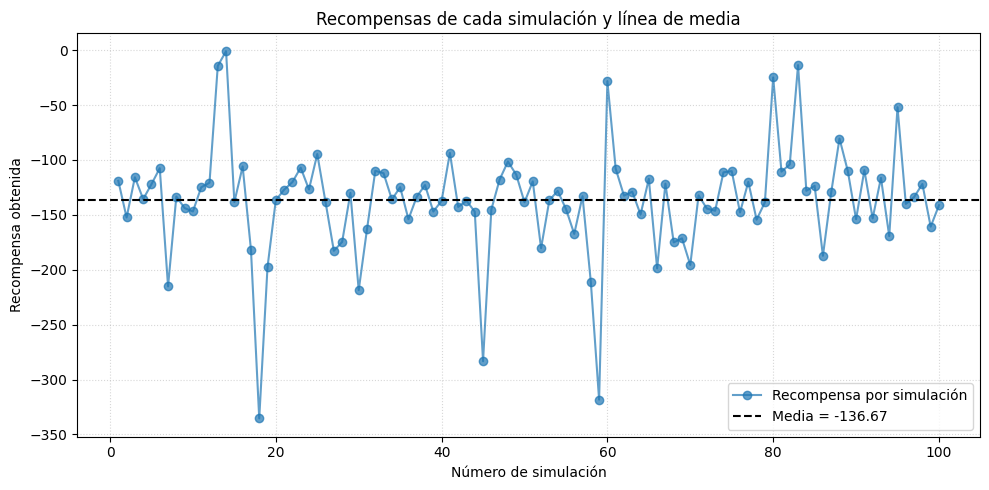

In [36]:
best_chromosome = np.load("best_chromosome1.npy")
print("Evaluating the best chromosome...")
results = evaluate_best_chromosome(best_chromosome)
plot_rewards(results["rewards"])

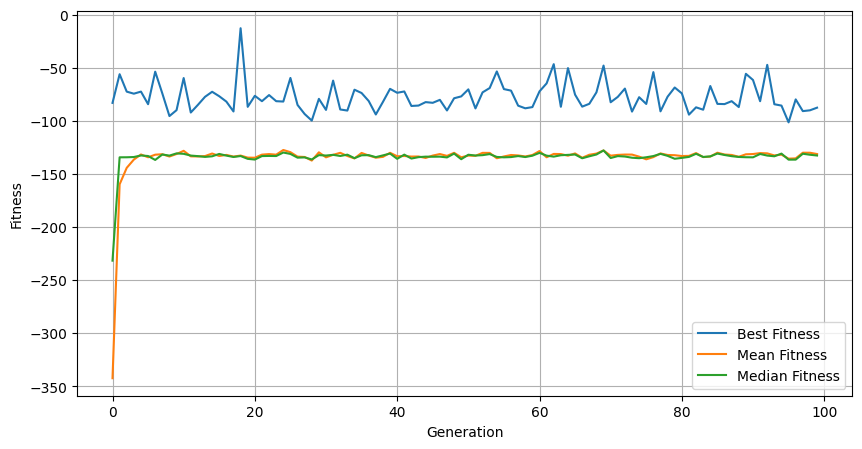

In [22]:
best_0 = np.load("best1.npy")
mean_0 = np.load("mean1.npy")
median_0 = np.load("median1.npy")

plt.figure(figsize=(10, 5))
plt.plot(best_0, label="Best Fitness")
plt.plot(mean_0, label="Mean Fitness")
plt.plot(median_0, label="Median Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid()
plt.show()

In [23]:
mutation_rate = 0.1
best_chromosome= genetic_algorithm(2, population_size, chromosome_size, generations, mutation_rate, selection_method = 'tournament',crossover='plain')

[ 1.03367135 -0.0715296   1.95297104 -2.81132167  1.84829978  0.39370452
 -1.21426501 -2.71982568  2.9437644  -2.9590456   1.61875817  1.48060261
 -0.73536638 -0.03511529  2.57369035 -0.62727573  2.84373778  0.14648829
 -2.43832144  1.87985048 -1.72987929  0.32607471 -1.2463853   1.89685416
  1.9682554  -1.67053577  0.86900821 -2.42891027 -0.53002057 -2.41880843
 -2.13593401 -1.72682295 -0.14006307 -2.53431698 -1.58973731 -2.96068198]
Population Initialized
Generation 1, Best Fitness: -82.70493680464979
Generation 2, Best Fitness: -56.159039173547924
Generation 3, Best Fitness: -31.771577126605713
Generation 4, Best Fitness: -42.53783079708215
Generation 5, Best Fitness: -11.207185759177767
Generation 6, Best Fitness: -5.146021168150426
Generation 7, Best Fitness: -28.599838374982482
Generation 8, Best Fitness: 57.17438439903632
Generation 9, Best Fitness: 16.64829895587669
Generation 10, Best Fitness: 22.323651507443863
Generation 11, Best Fitness: 69.65516495696349
Generation 12, Bes

Evaluating the best chromosome...
Run 1/100 (seed=0): Reward = -19.32560379880519
Run 2/100 (seed=1): Reward = -25.778756092276254
Run 3/100 (seed=2): Reward = -15.172616486443829
Run 4/100 (seed=3): Reward = 245.04289468900657
Run 5/100 (seed=4): Reward = 25.467483381521106
Run 6/100 (seed=5): Reward = 1.9622685117892757
Run 7/100 (seed=6): Reward = -239.62235978836134
Run 8/100 (seed=7): Reward = 266.0560831796812
Run 9/100 (seed=8): Reward = -203.78428307633695
Run 10/100 (seed=9): Reward = -186.3666618392682
Run 11/100 (seed=10): Reward = -5.652889804260795
Run 12/100 (seed=11): Reward = -10.241994992064164
Run 13/100 (seed=12): Reward = 255.25559604564722
Run 14/100 (seed=13): Reward = 12.154553261076288
Run 15/100 (seed=14): Reward = -45.72912633790952
Run 16/100 (seed=15): Reward = 1.1354403956100327
Run 17/100 (seed=16): Reward = -211.0770251570028
Run 18/100 (seed=17): Reward = -183.65397905514465
Run 19/100 (seed=18): Reward = -240.74332337808025
Run 20/100 (seed=19): Reward 

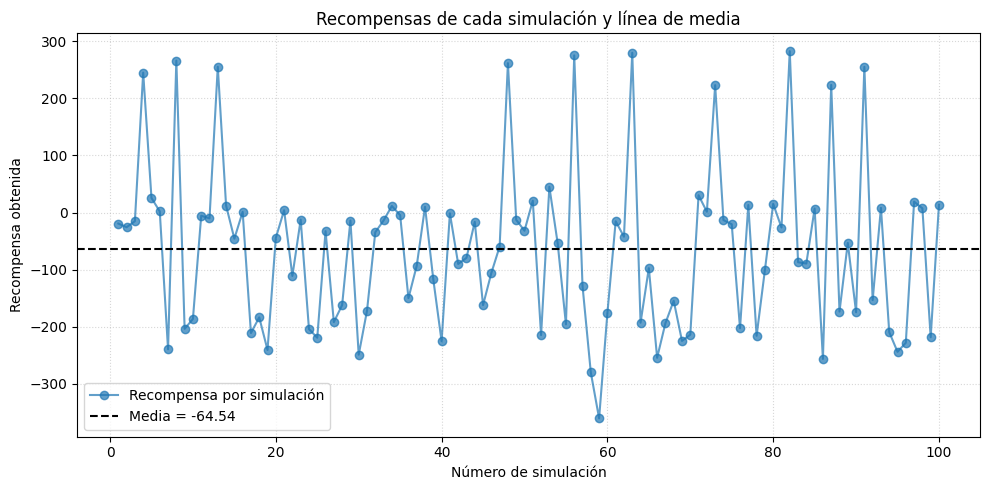

In [37]:
best_chromosome = np.load("best_chromosome2.npy")
print("Evaluating the best chromosome...")
results = evaluate_best_chromosome(best_chromosome)
plot_rewards(results["rewards"])

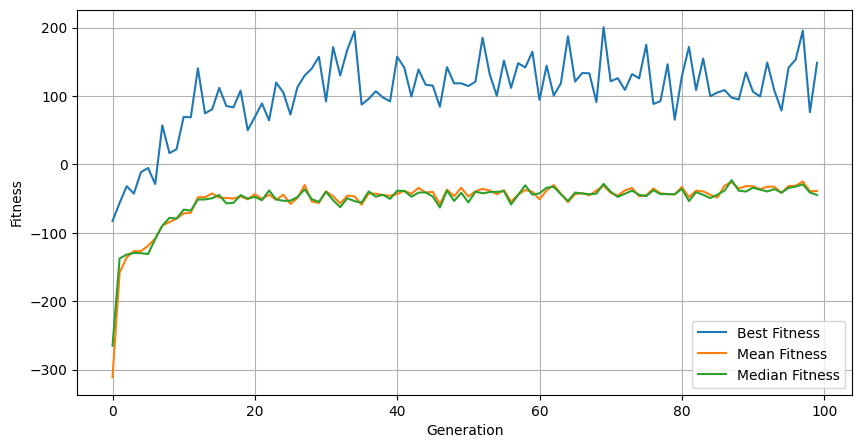

In [25]:
graficas("best2.npy", "mean2.npy", "median2.npy")

In [26]:
mutation_rate = 0.3
best_chromosome= genetic_algorithm(3, population_size, chromosome_size, generations, mutation_rate,selection_method = 'tournament' ,crossover='plain')

[ 1.03367135 -0.0715296   1.95297104 -2.81132167  1.84829978  0.39370452
 -1.21426501 -2.71982568  2.9437644  -2.9590456   1.61875817  1.48060261
 -0.73536638 -0.03511529  2.57369035 -0.62727573  2.84373778  0.14648829
 -2.43832144  1.87985048 -1.72987929  0.32607471 -1.2463853   1.89685416
  1.9682554  -1.67053577  0.86900821 -2.42891027 -0.53002057 -2.41880843
 -2.13593401 -1.72682295 -0.14006307 -2.53431698 -1.58973731 -2.96068198]
Population Initialized
Generation 1, Best Fitness: -70.79650178030248
Generation 2, Best Fitness: -34.51164266892397
Generation 3, Best Fitness: -62.97323238641245
Generation 4, Best Fitness: -55.587647578835075
Generation 5, Best Fitness: 0.955080603186326
Generation 6, Best Fitness: -24.47418014943521
Generation 7, Best Fitness: -1.0445722416478191
Generation 8, Best Fitness: -8.465408550757283
Generation 9, Best Fitness: -8.767001213920452
Generation 10, Best Fitness: 7.05069769375247
Generation 11, Best Fitness: 42.63449281491608
Generation 12, Best F

Evaluating the best chromosome...
Run 1/100 (seed=0): Reward = 19.59661105405206
Run 2/100 (seed=1): Reward = -179.62845417006358
Run 3/100 (seed=2): Reward = 232.40194409819364
Run 4/100 (seed=3): Reward = 209.31769018408392
Run 5/100 (seed=4): Reward = 247.90748237592786
Run 6/100 (seed=5): Reward = 240.95544539820528
Run 7/100 (seed=6): Reward = -249.47391762005537
Run 8/100 (seed=7): Reward = -31.069544968260374
Run 9/100 (seed=8): Reward = -23.082457900747485
Run 10/100 (seed=9): Reward = -234.63907143132485
Run 11/100 (seed=10): Reward = 248.51448369426816
Run 12/100 (seed=11): Reward = -31.695892007583282
Run 13/100 (seed=12): Reward = -378.9660965480766
Run 14/100 (seed=13): Reward = -262.5797930431319
Run 15/100 (seed=14): Reward = 244.9431566061353
Run 16/100 (seed=15): Reward = 272.866380160503
Run 17/100 (seed=16): Reward = -223.22552524254417
Run 18/100 (seed=17): Reward = -379.7533457169889
Run 19/100 (seed=18): Reward = -174.06798203884668
Run 20/100 (seed=19): Reward = 

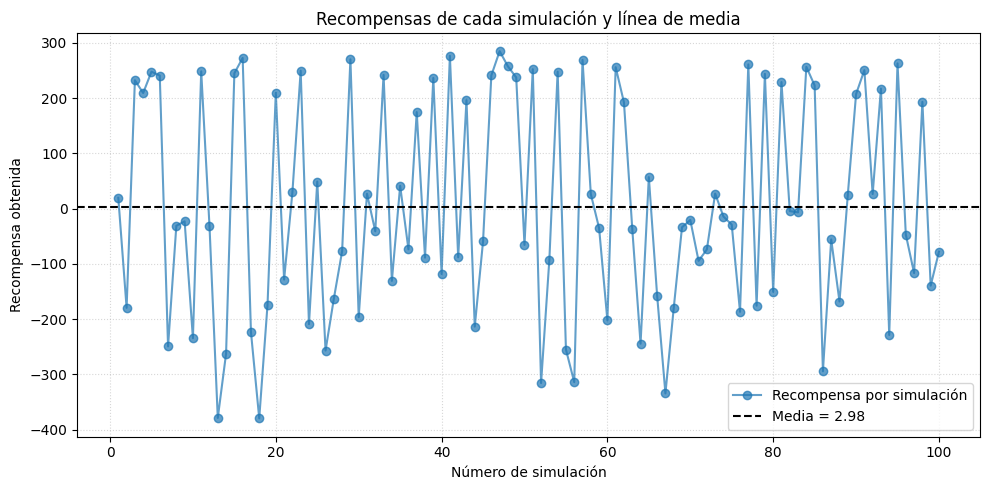

In [38]:
best_chromosome = np.load("best_chromosome3.npy")
print("Evaluating the best chromosome...")
results = evaluate_best_chromosome(best_chromosome)
plot_rewards(results["rewards"])

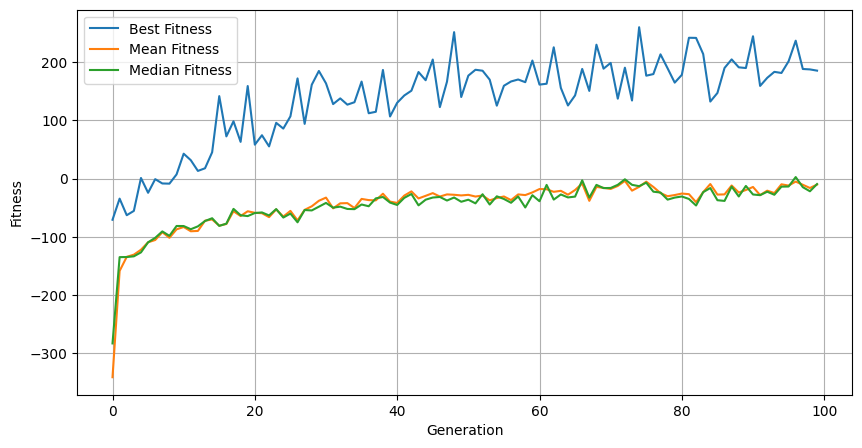

In [28]:
graficas("best3.npy", "mean3.npy", "median3.npy")

Tras realizar las pruebas con mutacion y probar diversas veces hay veces que el algoritmo converge a una solucion y otras veces no.

## Cruce Morfologico

In [29]:
# Hyperparameters
population_size = 100
chromosome_size = 8 * 4 + 4  # Weights + Biases
generations = 100
mutation_rate = 0

In [30]:
best_chromosome= genetic_algorithm(4, population_size, chromosome_size, generations, mutation_rate,selection_method = 'tournament' ,crossover='morphological')

[ 1.03367135 -0.0715296   1.95297104 -2.81132167  1.84829978  0.39370452
 -1.21426501 -2.71982568  2.9437644  -2.9590456   1.61875817  1.48060261
 -0.73536638 -0.03511529  2.57369035 -0.62727573  2.84373778  0.14648829
 -2.43832144  1.87985048 -1.72987929  0.32607471 -1.2463853   1.89685416
  1.9682554  -1.67053577  0.86900821 -2.42891027 -0.53002057 -2.41880843
 -2.13593401 -1.72682295 -0.14006307 -2.53431698 -1.58973731 -2.96068198]
Population Initialized
Generation 1, Best Fitness: -41.33674010220265
Generation 2, Best Fitness: -52.14082545922258
Generation 3, Best Fitness: -81.39586089748339
Generation 4, Best Fitness: -55.67654368390132
Generation 5, Best Fitness: -95.50514791616537
Generation 6, Best Fitness: -64.05978231403958
Generation 7, Best Fitness: -97.82536615866604
Generation 8, Best Fitness: -48.332156582803904
Generation 9, Best Fitness: -75.9849691554659
Generation 10, Best Fitness: -84.67075053600796
Generation 11, Best Fitness: -82.0324193482122
Generation 12, Best 

Evaluating the best chromosome...
Run 1/100 (seed=0): Reward = -68.77919501710639
Run 2/100 (seed=1): Reward = -175.47821208313485
Run 3/100 (seed=2): Reward = 189.55013207761098
Run 4/100 (seed=3): Reward = -50.88969110295669
Run 5/100 (seed=4): Reward = -275.3622213963341
Run 6/100 (seed=5): Reward = 246.0133270077062
Run 7/100 (seed=6): Reward = -269.4882640866005
Run 8/100 (seed=7): Reward = -195.80418617590624
Run 9/100 (seed=8): Reward = -212.16060449556204
Run 10/100 (seed=9): Reward = -271.804679884709
Run 11/100 (seed=10): Reward = -4.705580390736259
Run 12/100 (seed=11): Reward = -59.26570777923712
Run 13/100 (seed=12): Reward = -312.03937393073227
Run 14/100 (seed=13): Reward = -191.6468557528076
Run 15/100 (seed=14): Reward = -36.15957371012581
Run 16/100 (seed=15): Reward = -4.795320498330824
Run 17/100 (seed=16): Reward = -273.6506163526619
Run 18/100 (seed=17): Reward = -258.5422826058448
Run 19/100 (seed=18): Reward = -113.90782136228346
Run 20/100 (seed=19): Reward = -

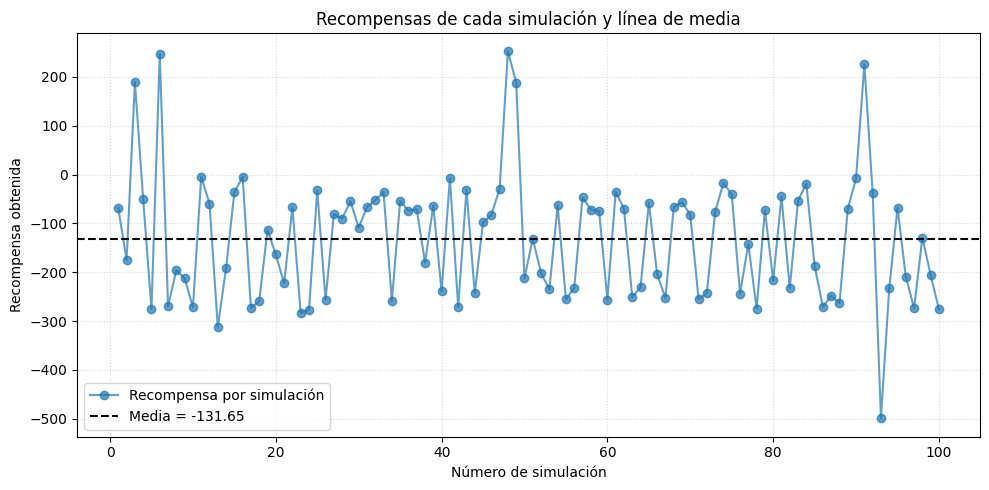

In [39]:
best_chromosome = np.load("best_chromosome4.npy")
print("Evaluating the best chromosome...")
results = evaluate_best_chromosome(best_chromosome)
plot_rewards(results["rewards"])

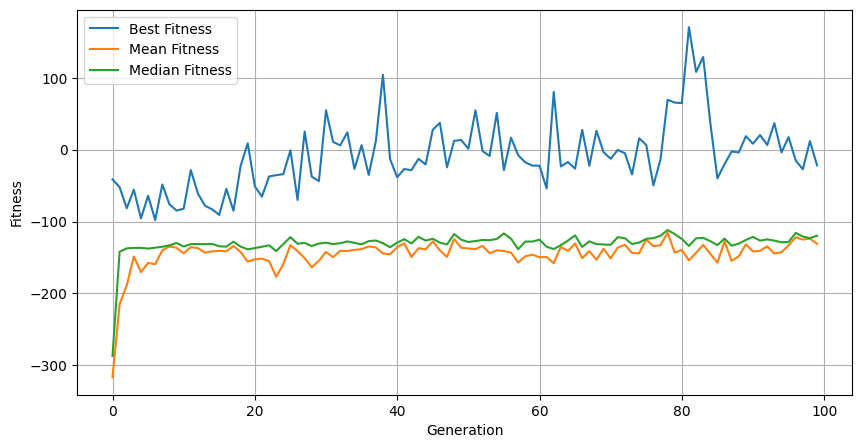

In [32]:
graficas("best4.npy", "mean4.npy", "median4.npy")

In [33]:
mutation_rate = 0.1
best_chromosome= genetic_algorithm(5, population_size, chromosome_size, generations, mutation_rate,selection_method = 'tournament' ,crossover='morphological')

[ 1.03367135 -0.0715296   1.95297104 -2.81132167  1.84829978  0.39370452
 -1.21426501 -2.71982568  2.9437644  -2.9590456   1.61875817  1.48060261
 -0.73536638 -0.03511529  2.57369035 -0.62727573  2.84373778  0.14648829
 -2.43832144  1.87985048 -1.72987929  0.32607471 -1.2463853   1.89685416
  1.9682554  -1.67053577  0.86900821 -2.42891027 -0.53002057 -2.41880843
 -2.13593401 -1.72682295 -0.14006307 -2.53431698 -1.58973731 -2.96068198]
Population Initialized
Generation 1, Best Fitness: -95.4376771990421
Generation 2, Best Fitness: -44.684907730828
Generation 3, Best Fitness: -20.58295210471274
Generation 4, Best Fitness: -42.40000881599648
Generation 5, Best Fitness: -74.58436311746168
Generation 6, Best Fitness: -59.867393809403175
Generation 7, Best Fitness: -49.4137086335622
Generation 8, Best Fitness: -25.684749358578433
Generation 9, Best Fitness: -69.17544571365991
Generation 10, Best Fitness: -65.3629959170826
Generation 11, Best Fitness: -70.16898171141163
Generation 12, Best Fi

Evaluating the best chromosome...
Run 1/100 (seed=0): Reward = -46.03289042289276
Run 2/100 (seed=1): Reward = -147.6591285051874
Run 3/100 (seed=2): Reward = -10.548197444105128
Run 4/100 (seed=3): Reward = -203.4047305588527
Run 5/100 (seed=4): Reward = -19.434009686920078
Run 6/100 (seed=5): Reward = -194.06627967261386
Run 7/100 (seed=6): Reward = -142.19464660188208
Run 8/100 (seed=7): Reward = -79.30469798258272
Run 9/100 (seed=8): Reward = -91.85232777860945
Run 10/100 (seed=9): Reward = -176.6218869960241
Run 11/100 (seed=10): Reward = -9.2353492893114
Run 12/100 (seed=11): Reward = -80.86143177458753
Run 13/100 (seed=12): Reward = 14.0946192741293
Run 14/100 (seed=13): Reward = -139.9087436631471
Run 15/100 (seed=14): Reward = -107.45209324949558
Run 16/100 (seed=15): Reward = 3.615191855052828
Run 17/100 (seed=16): Reward = -129.41408164961769
Run 18/100 (seed=17): Reward = -244.3213757287774
Run 19/100 (seed=18): Reward = -189.45182894520008
Run 20/100 (seed=19): Reward = 8.

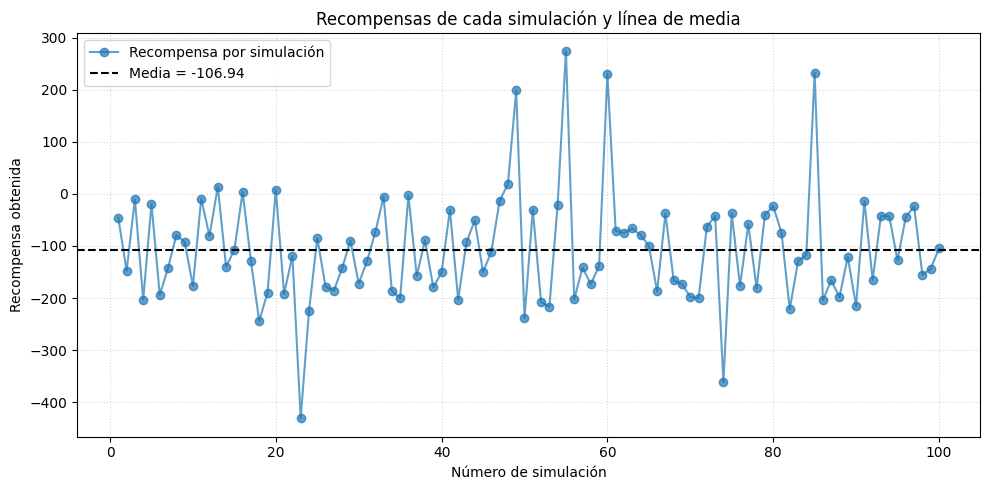

In [40]:
best_chromosome = np.load("best_chromosome5.npy")
print("Evaluating the best chromosome...")
results = evaluate_best_chromosome(best_chromosome)
plot_rewards(results["rewards"])

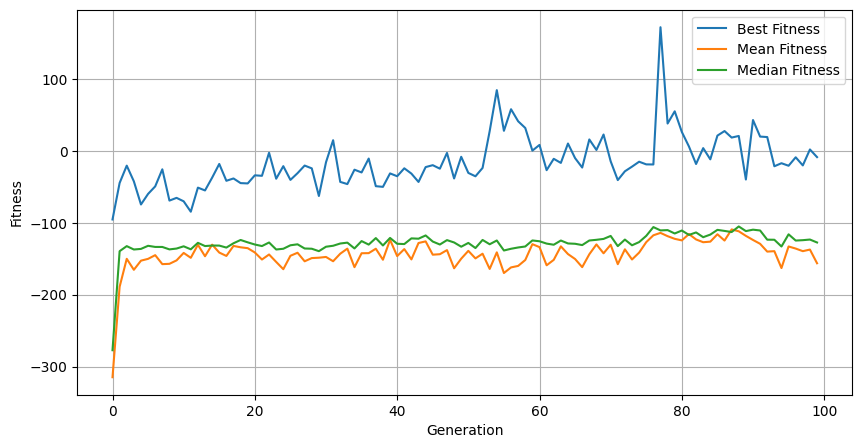

In [35]:
graficas("best5.npy", "mean5.npy", "median5.npy")

In [36]:
mutation_rate = 0.3
best_chromosome= genetic_algorithm(6, population_size, chromosome_size, generations, mutation_rate,selection_method = 'tournament' ,crossover='morphological')

[ 1.03367135 -0.0715296   1.95297104 -2.81132167  1.84829978  0.39370452
 -1.21426501 -2.71982568  2.9437644  -2.9590456   1.61875817  1.48060261
 -0.73536638 -0.03511529  2.57369035 -0.62727573  2.84373778  0.14648829
 -2.43832144  1.87985048 -1.72987929  0.32607471 -1.2463853   1.89685416
  1.9682554  -1.67053577  0.86900821 -2.42891027 -0.53002057 -2.41880843
 -2.13593401 -1.72682295 -0.14006307 -2.53431698 -1.58973731 -2.96068198]
Population Initialized
Generation 1, Best Fitness: -49.892767452089466
Generation 2, Best Fitness: -69.55568614619528
Generation 3, Best Fitness: -80.51498887758844
Generation 4, Best Fitness: -69.47663071871415
Generation 5, Best Fitness: -65.00258340146146
Generation 6, Best Fitness: -59.507212229920526
Generation 7, Best Fitness: -4.264182510590691
Generation 8, Best Fitness: -57.97105734880108
Generation 9, Best Fitness: -75.13653827627118
Generation 10, Best Fitness: -30.231240651690467
Generation 11, Best Fitness: -62.08914749845461
Generation 12, B

Evaluating the best chromosome...
Run 1/100 (seed=0): Reward = 53.31644526461852
Run 2/100 (seed=1): Reward = -88.81753089804958
Run 3/100 (seed=2): Reward = 1.3442230299021958
Run 4/100 (seed=3): Reward = -33.72240056774767
Run 5/100 (seed=4): Reward = 33.30603014114746
Run 6/100 (seed=5): Reward = 1.9117201856113724
Run 7/100 (seed=6): Reward = -288.4288996560111
Run 8/100 (seed=7): Reward = -109.11927378534213
Run 9/100 (seed=8): Reward = -94.68706699168129
Run 10/100 (seed=9): Reward = -237.00405126719687
Run 11/100 (seed=10): Reward = 3.463767156263657
Run 12/100 (seed=11): Reward = 38.57569733903384
Run 13/100 (seed=12): Reward = -109.78395614406183
Run 14/100 (seed=13): Reward = -171.29107805395142
Run 15/100 (seed=14): Reward = -2.8436463730282497
Run 16/100 (seed=15): Reward = 38.09713522094768
Run 17/100 (seed=16): Reward = -138.49366137410462
Run 18/100 (seed=17): Reward = -220.83364673989422
Run 19/100 (seed=18): Reward = 6.8824818009529025
Run 20/100 (seed=19): Reward = -3

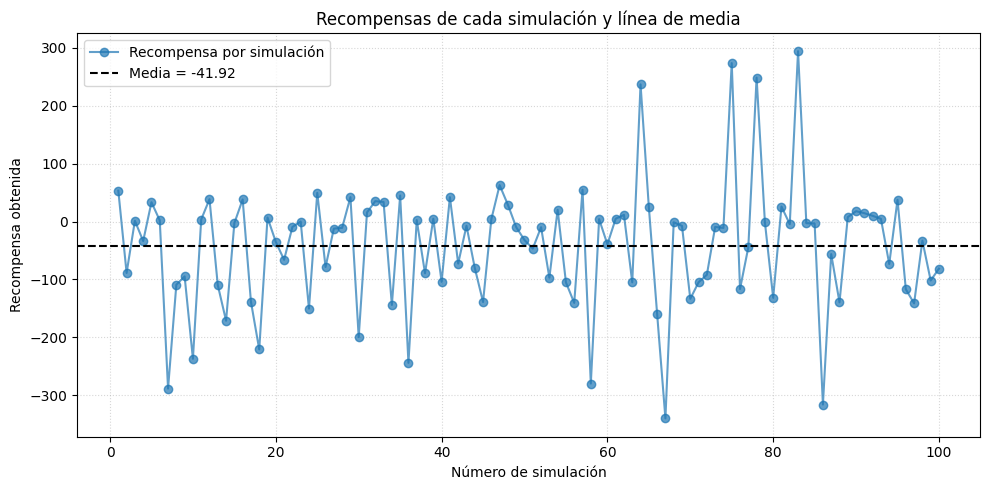

In [41]:
best_chromosome = np.load("best_chromosome6.npy")
print("Evaluating the best chromosome...")
results = evaluate_best_chromosome(best_chromosome)
plot_rewards(results["rewards"])

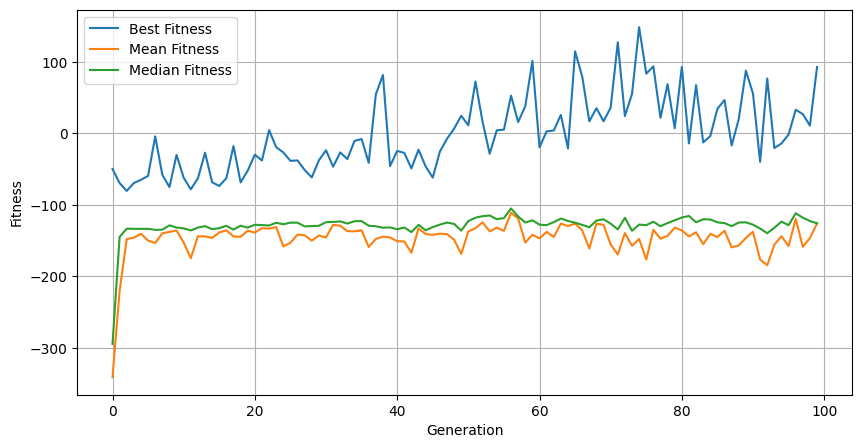

In [38]:
graficas("best6.npy", "mean6.npy", "median6.npy")

## Cruece Blx

Para estas pruebas vamos a cambiar el parametro α para buscar un equilibrio entre la exploracion y la explotacion. Se utiliza seleccion por torneo con k=5, con el cruce BLX inicialmente sin mutacion. Se utiliza una poblacion de 100

In [44]:
# Hyperparameters
population_size = 100
chromosome_size = 8 * 4 + 4  # Weights + Biases
generations = 100
mutation_rate = 0

In [40]:
alpha = 0.3
best_chromosome= genetic_algorithm(7, population_size, chromosome_size, generations, mutation_rate, crossover='blx_alpha',selection_method="tournament", alpha=alpha)

[ 1.03367135 -0.0715296   1.95297104 -2.81132167  1.84829978  0.39370452
 -1.21426501 -2.71982568  2.9437644  -2.9590456   1.61875817  1.48060261
 -0.73536638 -0.03511529  2.57369035 -0.62727573  2.84373778  0.14648829
 -2.43832144  1.87985048 -1.72987929  0.32607471 -1.2463853   1.89685416
  1.9682554  -1.67053577  0.86900821 -2.42891027 -0.53002057 -2.41880843
 -2.13593401 -1.72682295 -0.14006307 -2.53431698 -1.58973731 -2.96068198]
Population Initialized
Generation 1, Best Fitness: -89.94687303221292
Generation 2, Best Fitness: -57.229797663388105
Generation 3, Best Fitness: -62.70215306994589
Generation 4, Best Fitness: -38.60281351529882
Generation 5, Best Fitness: -9.151238555957312
Generation 6, Best Fitness: -47.14137176140094
Generation 7, Best Fitness: -40.80664072295424
Generation 8, Best Fitness: -31.91982226942239
Generation 9, Best Fitness: 29.052056178647092
Generation 10, Best Fitness: -18.915088269811772
Generation 11, Best Fitness: -21.027894029327207
Generation 12, B

Evaluating the best chromosome...
Run 1/100 (seed=0): Reward = -34.87745262130413
Run 2/100 (seed=1): Reward = 10.0797361604683
Run 3/100 (seed=2): Reward = 8.030795396159562
Run 4/100 (seed=3): Reward = 236.13394216202857
Run 5/100 (seed=4): Reward = 41.67559855753723
Run 6/100 (seed=5): Reward = 91.76673054418762
Run 7/100 (seed=6): Reward = -129.5897891892761
Run 8/100 (seed=7): Reward = 261.6513963290256
Run 9/100 (seed=8): Reward = -6.813693103410671
Run 10/100 (seed=9): Reward = 23.34157985099833
Run 11/100 (seed=10): Reward = 9.769304136258285
Run 12/100 (seed=11): Reward = -5.69722186757285
Run 13/100 (seed=12): Reward = 42.91986403246668
Run 14/100 (seed=13): Reward = 2.0737017057687552
Run 15/100 (seed=14): Reward = -70.35029709167706
Run 16/100 (seed=15): Reward = 18.88542734644706
Run 17/100 (seed=16): Reward = -205.84695786860675
Run 18/100 (seed=17): Reward = -167.71030373633437
Run 19/100 (seed=18): Reward = -202.06644766266686
Run 20/100 (seed=19): Reward = 258.82358346

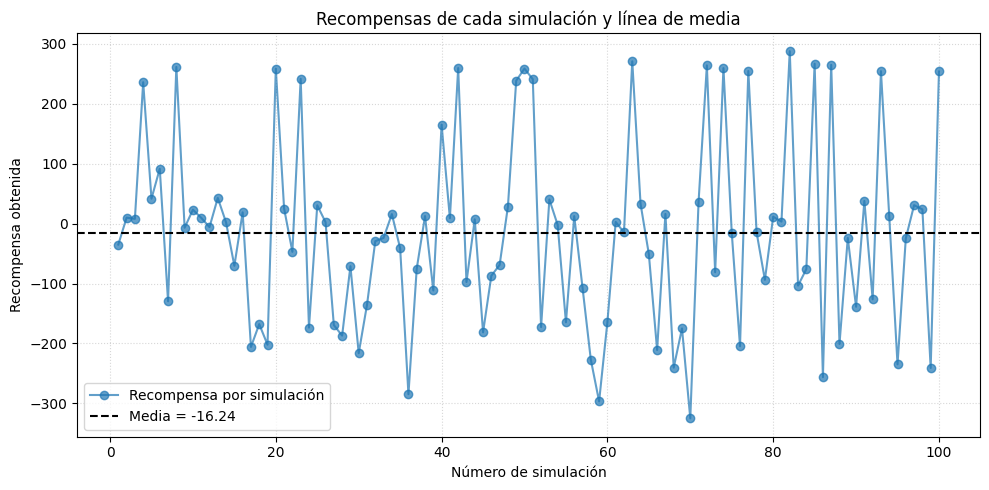

In [42]:
best_chromosome = np.load("best_chromosome7.npy")
print("Evaluating the best chromosome...")
results = evaluate_best_chromosome(best_chromosome)
plot_rewards(results["rewards"])

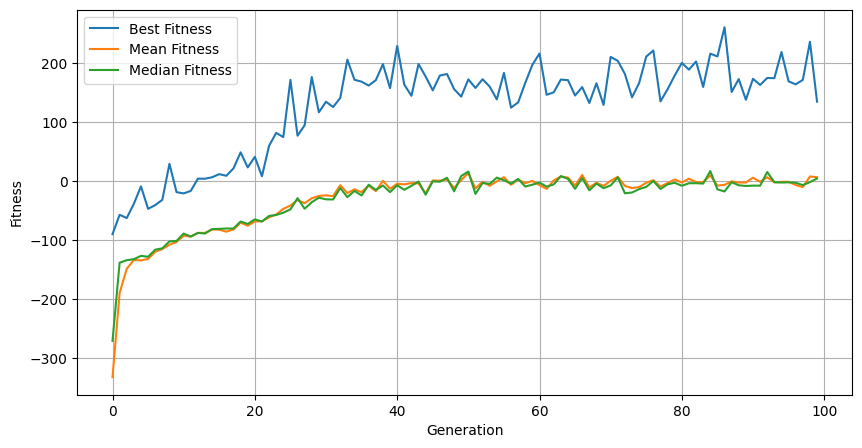

In [42]:
graficas("best7.npy", "mean7.npy", "median7.npy")

In [45]:
alpha = 0.5
best_chromosome= genetic_algorithm(8, population_size, chromosome_size, generations, mutation_rate, crossover='blx_alpha',selection_method="tournament" ,alpha=alpha)

[ 1.03367135 -0.0715296   1.95297104 -2.81132167  1.84829978  0.39370452
 -1.21426501 -2.71982568  2.9437644  -2.9590456   1.61875817  1.48060261
 -0.73536638 -0.03511529  2.57369035 -0.62727573  2.84373778  0.14648829
 -2.43832144  1.87985048 -1.72987929  0.32607471 -1.2463853   1.89685416
  1.9682554  -1.67053577  0.86900821 -2.42891027 -0.53002057 -2.41880843
 -2.13593401 -1.72682295 -0.14006307 -2.53431698 -1.58973731 -2.96068198]
Population Initialized
Generation 1, Best Fitness: -99.74768254302164
Generation 2, Best Fitness: -44.825380312891184
Generation 3, Best Fitness: -51.18228421608377
Generation 4, Best Fitness: -66.37231036723409
Generation 5, Best Fitness: -72.77705181555909
Generation 6, Best Fitness: -11.505909230628117
Generation 7, Best Fitness: -36.815015983503784
Generation 8, Best Fitness: -15.054985739499873
Generation 9, Best Fitness: -30.896282703891814
Generation 10, Best Fitness: -7.658030172738984
Generation 11, Best Fitness: -38.33634039894049
Generation 12,

Evaluating the best chromosome...
Run 1/100 (seed=0): Reward = 2.6389896099308743
Run 2/100 (seed=1): Reward = -52.9823049351582
Run 3/100 (seed=2): Reward = -2.323246744879654
Run 4/100 (seed=3): Reward = 1.6819041265730306
Run 5/100 (seed=4): Reward = 42.208427432599166
Run 6/100 (seed=5): Reward = 19.621239342227256
Run 7/100 (seed=6): Reward = -193.90753016546864
Run 8/100 (seed=7): Reward = -78.78166808367378
Run 9/100 (seed=8): Reward = 262.144337903141
Run 10/100 (seed=9): Reward = -178.41253276271135
Run 11/100 (seed=10): Reward = 229.8830152792358
Run 12/100 (seed=11): Reward = -27.076570946822486
Run 13/100 (seed=12): Reward = -223.23915602001904
Run 14/100 (seed=13): Reward = 20.920524231039394
Run 15/100 (seed=14): Reward = 240.32225476885287
Run 16/100 (seed=15): Reward = 259.97416139612466
Run 17/100 (seed=16): Reward = -177.9326512104912
Run 18/100 (seed=17): Reward = -187.54702720007842
Run 19/100 (seed=18): Reward = -213.0946643273637
Run 20/100 (seed=19): Reward = -28

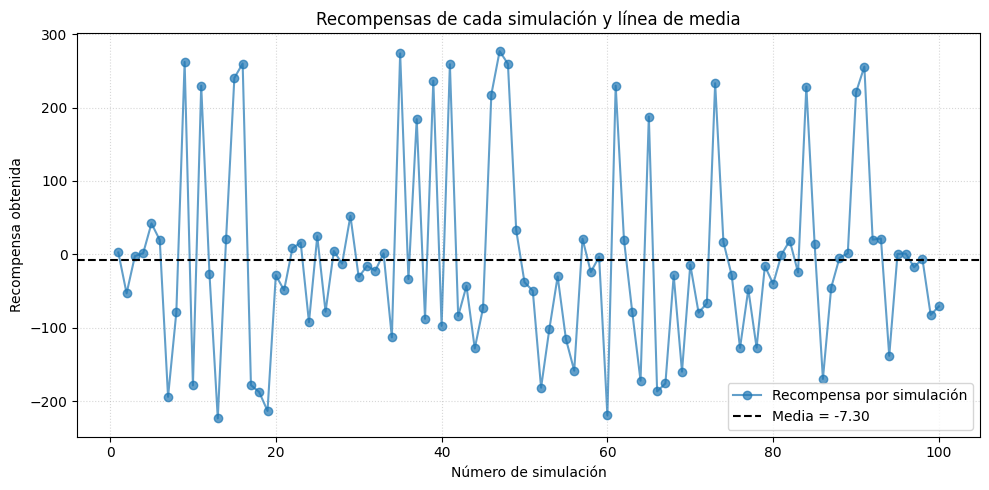

In [46]:
best_chromosome = np.load("best_chromosome8.npy")
print("Evaluating the best chromosome...")
results = evaluate_best_chromosome(best_chromosome)
plot_rewards(results["rewards"])

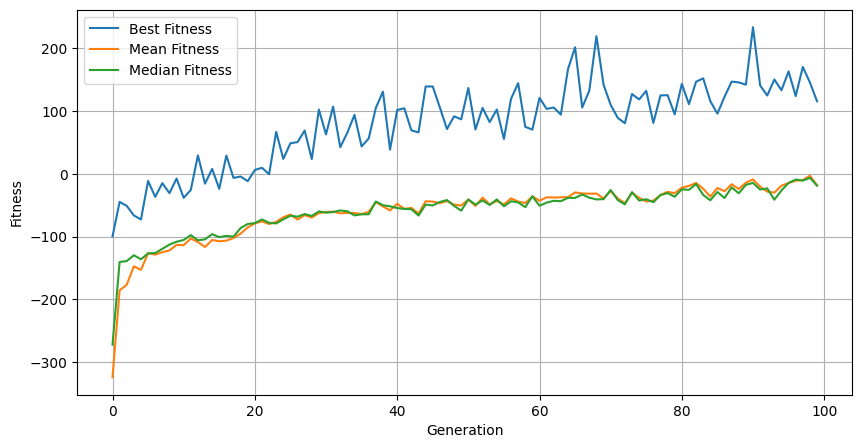

In [47]:
graficas("best8.npy", "mean8.npy", "median8.npy")

In [50]:
alpha = 0.7
best_chromosome= genetic_algorithm(9, population_size, chromosome_size, generations, mutation_rate, crossover='blx_alpha',selection_method="tournament", alpha=alpha)

[ 1.03367135 -0.0715296   1.95297104 -2.81132167  1.84829978  0.39370452
 -1.21426501 -2.71982568  2.9437644  -2.9590456   1.61875817  1.48060261
 -0.73536638 -0.03511529  2.57369035 -0.62727573  2.84373778  0.14648829
 -2.43832144  1.87985048 -1.72987929  0.32607471 -1.2463853   1.89685416
  1.9682554  -1.67053577  0.86900821 -2.42891027 -0.53002057 -2.41880843
 -2.13593401 -1.72682295 -0.14006307 -2.53431698 -1.58973731 -2.96068198]
Population Initialized
Generation 1, Best Fitness: -90.11416752399653
Generation 2, Best Fitness: -81.47406907648113
Generation 3, Best Fitness: -66.96245768256638
Generation 4, Best Fitness: -83.31265032812178
Generation 5, Best Fitness: -75.02244463705597
Generation 6, Best Fitness: -63.65408174838548
Generation 7, Best Fitness: -86.31624503282947
Generation 8, Best Fitness: -26.9849791402238
Generation 9, Best Fitness: -46.81239792629549
Generation 10, Best Fitness: -64.52335377508555
Generation 11, Best Fitness: -34.86198342038334
Generation 12, Best 

Evaluating the best chromosome...
Run 1/100 (seed=0): Reward = 279.9708760287483
Run 2/100 (seed=1): Reward = 232.43126754492667
Run 3/100 (seed=2): Reward = 214.78602567800752
Run 4/100 (seed=3): Reward = 183.48080656263113
Run 5/100 (seed=4): Reward = 195.80009277059105
Run 6/100 (seed=5): Reward = 239.0984244028199
Run 7/100 (seed=6): Reward = 268.706424780853
Run 8/100 (seed=7): Reward = 229.46120892380256
Run 9/100 (seed=8): Reward = 257.2899824040627
Run 10/100 (seed=9): Reward = 249.41532965706745
Run 11/100 (seed=10): Reward = 231.05173195672734
Run 12/100 (seed=11): Reward = 235.42410669649868
Run 13/100 (seed=12): Reward = 264.94342106242397
Run 14/100 (seed=13): Reward = 255.66685592516427
Run 15/100 (seed=14): Reward = 234.47046991147488
Run 16/100 (seed=15): Reward = 253.61634057941018
Run 17/100 (seed=16): Reward = -75.31706568089517
Run 18/100 (seed=17): Reward = 271.53330532100836
Run 19/100 (seed=18): Reward = 286.8991022231479
Run 20/100 (seed=19): Reward = 213.416872

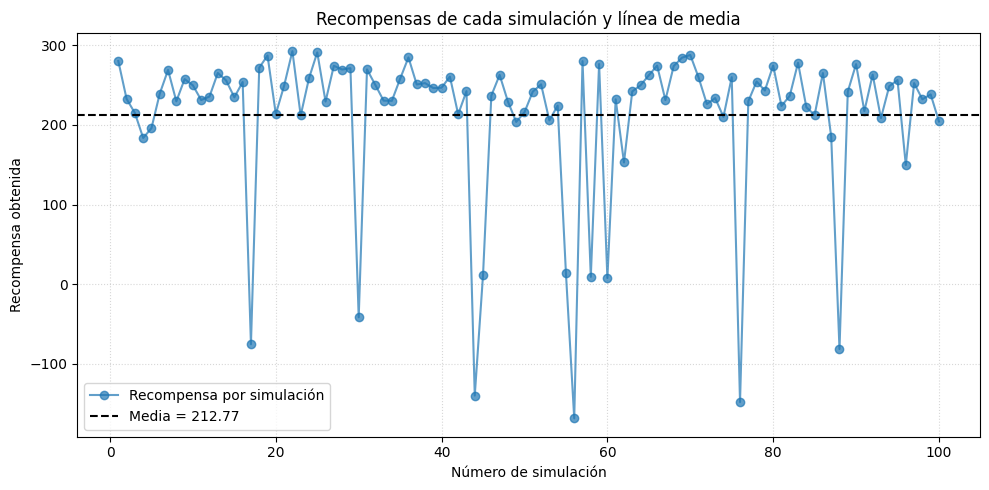

In [51]:
best_chromosome = np.load("best_chromosome9.npy")
print("Evaluating the best chromosome...")
results = evaluate_best_chromosome(best_chromosome)
plot_rewards(results["rewards"])

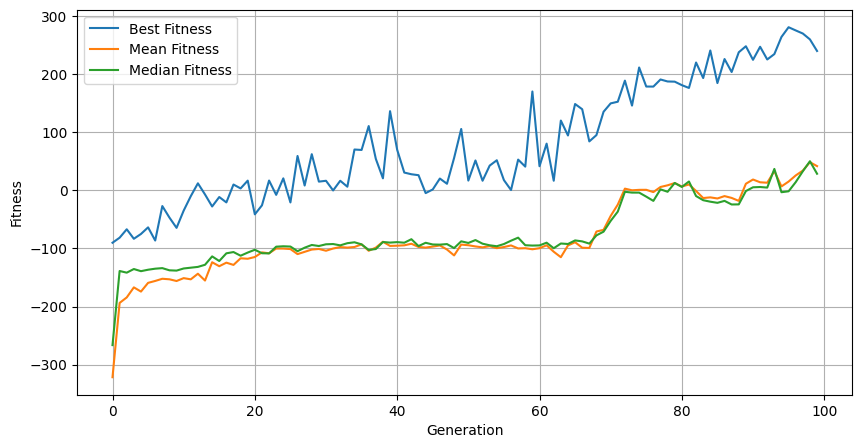

In [52]:
graficas("best9.npy", "mean9.npy", "median9.npy")

Se va a realizar pruebas con alpha = 0.5 y mutacion para ver si converge el algoritmo.

In [53]:
alpha = 0.5
mutation_rate = 0.1
best_chromosome= genetic_algorithm(10, population_size, chromosome_size, generations, mutation_rate,selection_method = 'tournament' ,crossover='blx_alpha', alpha=alpha)

[ 1.03367135 -0.0715296   1.95297104 -2.81132167  1.84829978  0.39370452
 -1.21426501 -2.71982568  2.9437644  -2.9590456   1.61875817  1.48060261
 -0.73536638 -0.03511529  2.57369035 -0.62727573  2.84373778  0.14648829
 -2.43832144  1.87985048 -1.72987929  0.32607471 -1.2463853   1.89685416
  1.9682554  -1.67053577  0.86900821 -2.42891027 -0.53002057 -2.41880843
 -2.13593401 -1.72682295 -0.14006307 -2.53431698 -1.58973731 -2.96068198]
Population Initialized
Generation 1, Best Fitness: -65.21495801541649
Generation 2, Best Fitness: -55.94613603015313
Generation 3, Best Fitness: -57.80363458691151
Generation 4, Best Fitness: -40.975998371166085
Generation 5, Best Fitness: -16.891356288467023
Generation 6, Best Fitness: -51.58518468515425
Generation 7, Best Fitness: -30.193006564766144
Generation 8, Best Fitness: -46.08399680162309
Generation 9, Best Fitness: -39.49400660235273
Generation 10, Best Fitness: -46.6136799195987
Generation 11, Best Fitness: 10.99322641879744
Generation 12, Bes

Evaluating the best chromosome...
Run 1/100 (seed=0): Reward = 291.21144351612827
Run 2/100 (seed=1): Reward = 259.74692121077635
Run 3/100 (seed=2): Reward = 237.79666816781207
Run 4/100 (seed=3): Reward = 235.3161340682081
Run 5/100 (seed=4): Reward = 250.54556622493533
Run 6/100 (seed=5): Reward = 263.93195645876176
Run 7/100 (seed=6): Reward = 67.39399449896976
Run 8/100 (seed=7): Reward = 267.05454605057287
Run 9/100 (seed=8): Reward = 287.77672552115314
Run 10/100 (seed=9): Reward = 299.4519252611541
Run 11/100 (seed=10): Reward = 249.0920378443262
Run 12/100 (seed=11): Reward = 249.61738516782052
Run 13/100 (seed=12): Reward = 295.61735585196266
Run 14/100 (seed=13): Reward = 294.79477251184346
Run 15/100 (seed=14): Reward = 247.30240978287742
Run 16/100 (seed=15): Reward = 262.16558144768715
Run 17/100 (seed=16): Reward = 287.47377461715104
Run 18/100 (seed=17): Reward = 317.1556281950792
Run 19/100 (seed=18): Reward = 287.4765453706731
Run 20/100 (seed=19): Reward = 240.902232

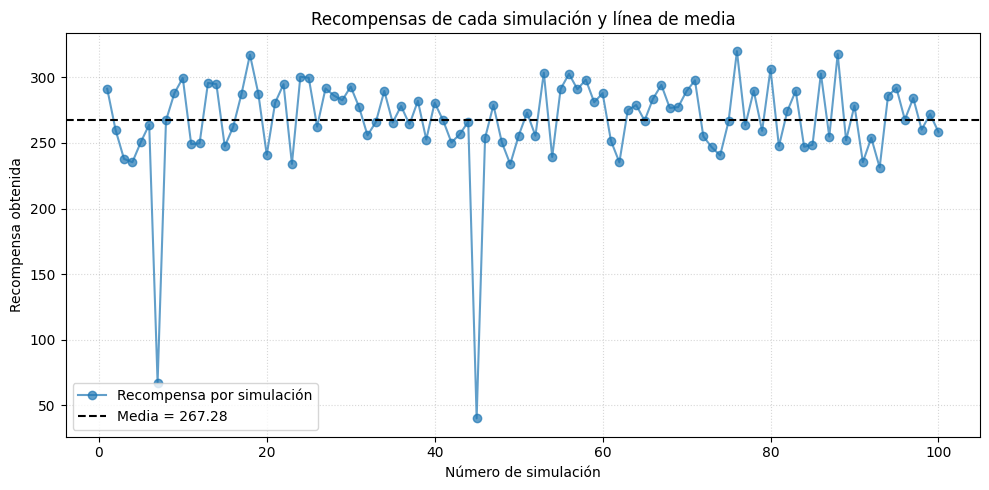

In [54]:
best_chromosome = np.load("best_chromosome10.npy")
print("Evaluating the best chromosome...")
results = evaluate_best_chromosome(best_chromosome)
plot_rewards(results["rewards"])

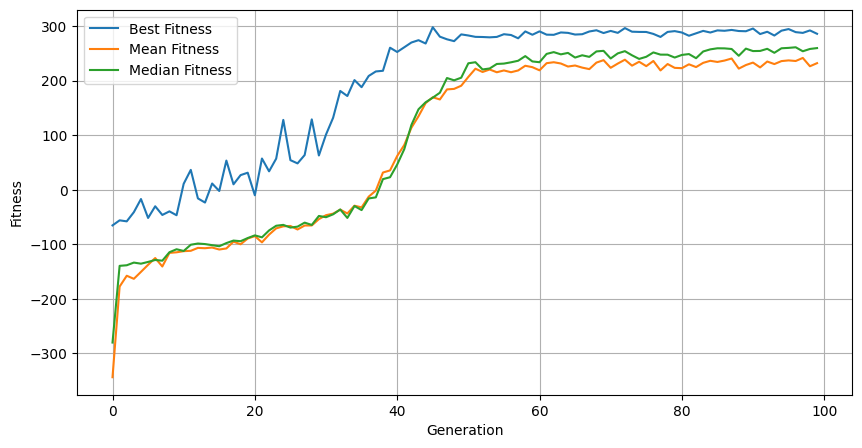

In [55]:
graficas("best10.npy", "mean10.npy", "median10.npy")

In [52]:
alpha = 0.5
mutation_rate = 0.3
best_chromosome= genetic_algorithm(11, population_size, chromosome_size, generations, mutation_rate, crossover='blx_alpha',selection_method = 'tournament' ,alpha=alpha)

[ 1.03367135 -0.0715296   1.95297104 -2.81132167  1.84829978  0.39370452
 -1.21426501 -2.71982568  2.9437644  -2.9590456   1.61875817  1.48060261
 -0.73536638 -0.03511529  2.57369035 -0.62727573  2.84373778  0.14648829
 -2.43832144  1.87985048 -1.72987929  0.32607471 -1.2463853   1.89685416
  1.9682554  -1.67053577  0.86900821 -2.42891027 -0.53002057 -2.41880843
 -2.13593401 -1.72682295 -0.14006307 -2.53431698 -1.58973731 -2.96068198]
Population Initialized
Generation 1, Best Fitness: -58.57595572284083
Generation 2, Best Fitness: -55.72084915374448
Generation 3, Best Fitness: -32.63111179060406
Generation 4, Best Fitness: -34.51773480948522
Generation 5, Best Fitness: -13.818137314715159
Generation 6, Best Fitness: -29.237490982895217
Generation 7, Best Fitness: -13.861884658970704
Generation 8, Best Fitness: -7.091558175704279
Generation 9, Best Fitness: -27.223099788942
Generation 10, Best Fitness: 2.7718011642448372
Generation 11, Best Fitness: -34.55783656704829
Generation 12, Bes

Evaluating the best chromosome...
Run 1/100 (seed=0): Reward = 311.61336478113344
Run 2/100 (seed=1): Reward = 266.38871618800397
Run 3/100 (seed=2): Reward = 245.97625461930048
Run 4/100 (seed=3): Reward = 244.57742823631423
Run 5/100 (seed=4): Reward = 261.20768454685617
Run 6/100 (seed=5): Reward = 273.8676012893839
Run 7/100 (seed=6): Reward = 325.3432095648676
Run 8/100 (seed=7): Reward = 270.951980217765
Run 9/100 (seed=8): Reward = 291.79250853905705
Run 10/100 (seed=9): Reward = 303.17918447594195
Run 11/100 (seed=10): Reward = 260.02931447582205
Run 12/100 (seed=11): Reward = 269.0782958980727
Run 13/100 (seed=12): Reward = 60.66875726678802
Run 14/100 (seed=13): Reward = 297.40004015186423
Run 15/100 (seed=14): Reward = 264.03460206848473
Run 16/100 (seed=15): Reward = 48.212041921715354
Run 17/100 (seed=16): Reward = 285.4961945151175
Run 18/100 (seed=17): Reward = 311.708442304806
Run 19/100 (seed=18): Reward = 303.9583682390945
Run 20/100 (seed=19): Reward = 249.1872161223

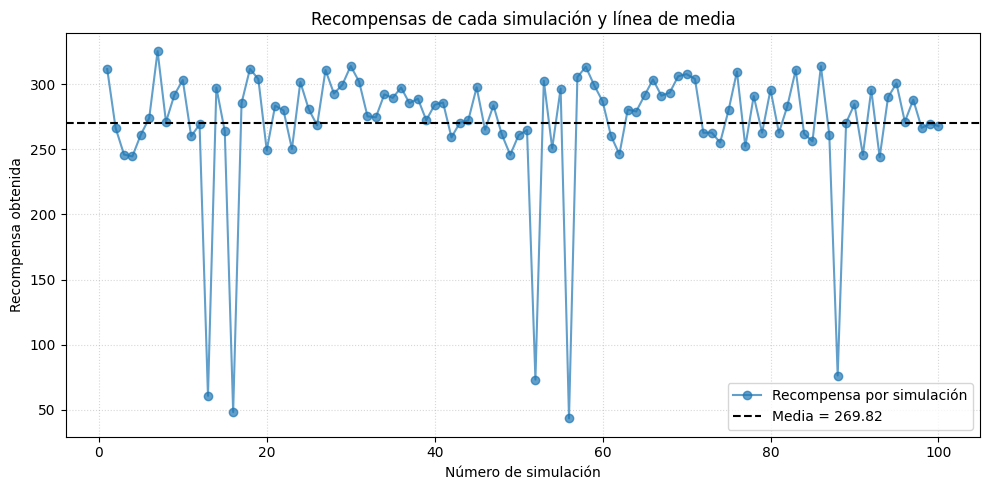

In [53]:
best_chromosome = np.load("best_chromosome11.npy")
print("Evaluating the best chromosome...")
results = evaluate_best_chromosome(best_chromosome)
plot_rewards(results["rewards"])

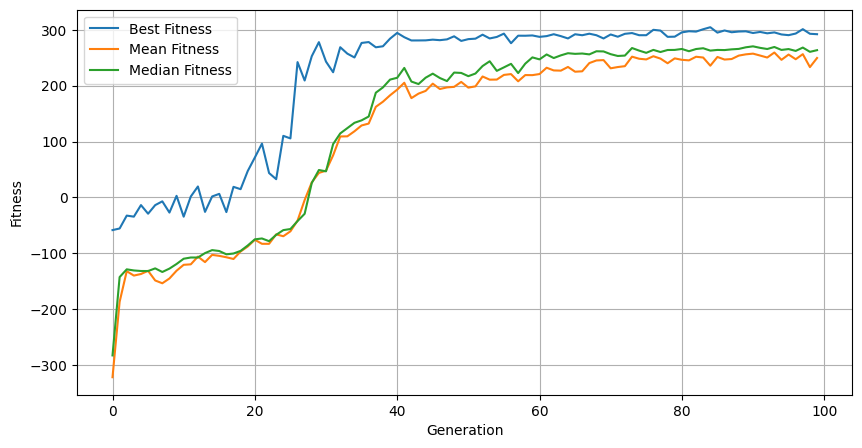

In [54]:
graficas("best11.npy", "mean11.npy", "median11.npy")

Tras haber probado distintas tasas de mutacion para el algoritmo genetico con el operador de
cruce BLX-0.5, se concluye que un poco de mutacion (con tasa = 0.1) ayudaria al modelo a
evitar posibles optimos locales, sin caer en la aleatoriedad de valores mas grandes de mutacion.

## Pruebas con distintos metodos de seleccion

Se van a realizar las pruebas con BLX-0.7 y sin mutacion, para ver si el metodo de seleccion influye en la convergencia del algoritmo.

In [19]:
# Hyperparameters
population_size = 100
chromosome_size = 8 * 4 + 4  # Weights + Biases
generations = 100
mutation_rate = 0
alpha = 0.7

In [20]:
K = 3
best_chromosome= genetic_algorithm(12, population_size, chromosome_size, generations, mutation_rate, crossover='blx_alpha',selection_method = 'tournament' ,alpha=alpha, k=K)

[-2.06388816 -2.06403288 -2.65149833  2.19705687  0.60669007  1.24843547
 -2.87649303  2.81945911  1.99465584 -1.72596534 -1.9090502  -1.89957294
 -1.17454654  0.14853859 -0.40832989 -1.25262516  0.67111737 -2.16303684
 -1.24713211 -0.80182894 -0.26358009  1.71105577 -1.80195731  0.08540663
  0.55448741 -2.72129752  0.64526911 -1.97685526 -2.60969044  2.69331322
  2.7937922   1.85038409 -1.17231738 -2.41396732  1.10539816 -0.35908504]
Population Initialized
Generation 1, Best Fitness: -90.78434781685687
Generation 2, Best Fitness: -88.2261031316712
Generation 3, Best Fitness: -59.405221161818545
Generation 4, Best Fitness: -65.53429034640996
Generation 5, Best Fitness: -71.92916887997998
Generation 6, Best Fitness: -50.48342749930784
Generation 7, Best Fitness: -79.45341411551684
Generation 8, Best Fitness: -71.86761869533368
Generation 9, Best Fitness: -67.01568771710171
Generation 10, Best Fitness: -81.8343200234244
Generation 11, Best Fitness: -60.41421559619575
Generation 12, Best 

Evaluating the best chromosome...
Run 1/100 (seed=0): Reward = -102.74424861482375
Run 2/100 (seed=1): Reward = -48.57207451333596
Run 3/100 (seed=2): Reward = 206.81958954541108
Run 4/100 (seed=3): Reward = 12.307137127744596
Run 5/100 (seed=4): Reward = -2.7978062705799402
Run 6/100 (seed=5): Reward = 108.19874430185673
Run 7/100 (seed=6): Reward = -215.15671649554582
Run 8/100 (seed=7): Reward = 222.78845111468294
Run 9/100 (seed=8): Reward = 232.427027855895
Run 10/100 (seed=9): Reward = -146.92287677099307
Run 11/100 (seed=10): Reward = 242.12276920933363
Run 12/100 (seed=11): Reward = 31.75248838477168
Run 13/100 (seed=12): Reward = -21.889168842292477
Run 14/100 (seed=13): Reward = 2.862698991630154
Run 15/100 (seed=14): Reward = 120.589303997269
Run 16/100 (seed=15): Reward = 208.07326127691994
Run 17/100 (seed=16): Reward = 192.5919683746292
Run 18/100 (seed=17): Reward = -335.3645612988132
Run 19/100 (seed=18): Reward = -174.0197569925667
Run 20/100 (seed=19): Reward = -1.487

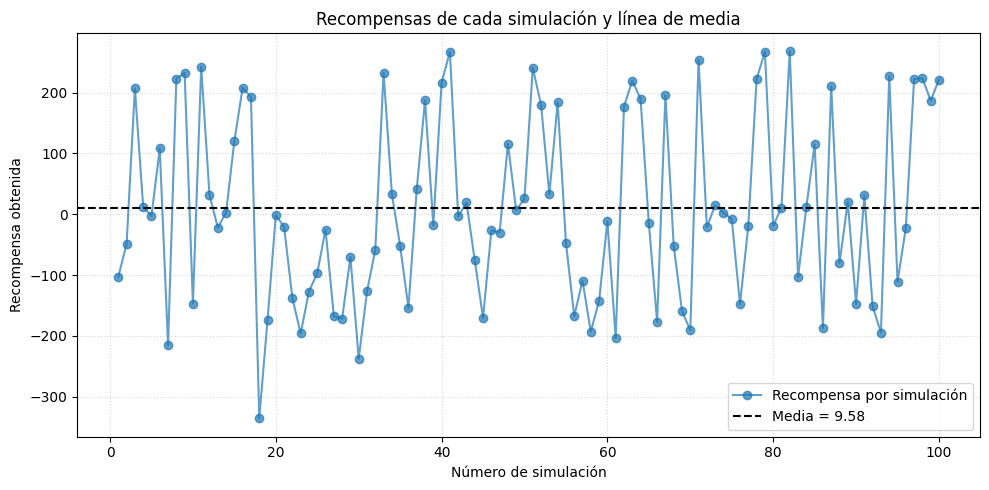

In [21]:
best_chromosome = np.load("best_chromosome12.npy")
print("Evaluating the best chromosome...")
results = evaluate_best_chromosome(best_chromosome)
plot_rewards(results["rewards"])

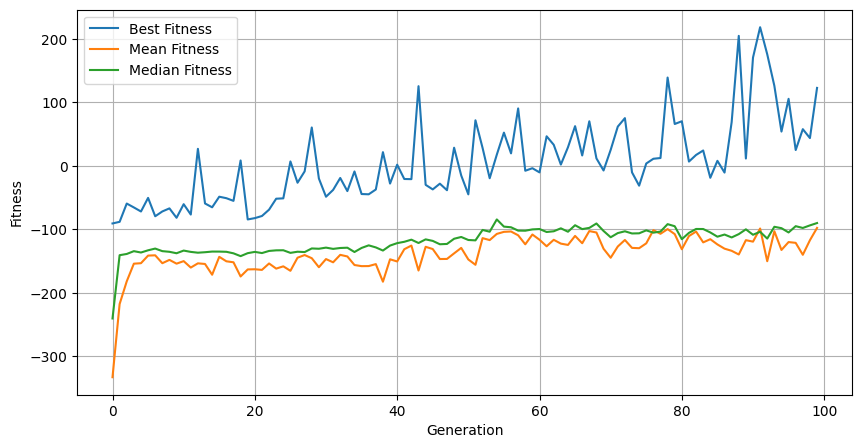

In [22]:
graficas("best12.npy", "mean12.npy", "median12.npy")

In [23]:
K = 7
best_chromosome= genetic_algorithm(13, population_size, chromosome_size, generations, mutation_rate, crossover='blx_alpha', alpha=alpha,selection_method = 'tournament' ,k=K)

[ 1.03367135 -0.0715296   1.95297104 -2.81132167  1.84829978  0.39370452
 -1.21426501 -2.71982568  2.9437644  -2.9590456   1.61875817  1.48060261
 -0.73536638 -0.03511529  2.57369035 -0.62727573  2.84373778  0.14648829
 -2.43832144  1.87985048 -1.72987929  0.32607471 -1.2463853   1.89685416
  1.9682554  -1.67053577  0.86900821 -2.42891027 -0.53002057 -2.41880843
 -2.13593401 -1.72682295 -0.14006307 -2.53431698 -1.58973731 -2.96068198]
Population Initialized
Generation 1, Best Fitness: -75.15365814812778
Generation 2, Best Fitness: -69.11845295517159
Generation 3, Best Fitness: -76.16212983743436
Generation 4, Best Fitness: -65.42059517216923
Generation 5, Best Fitness: -28.92472467936467
Generation 6, Best Fitness: -59.27334850612389
Generation 7, Best Fitness: -45.90757609991112
Generation 8, Best Fitness: -7.914059819670851
Generation 9, Best Fitness: -35.98516462156262
Generation 10, Best Fitness: 6.211868740684548
Generation 11, Best Fitness: -18.912472350793962
Generation 12, Best

Evaluating the best chromosome...
Run 1/100 (seed=0): Reward = 299.76627470123367
Run 2/100 (seed=1): Reward = 259.0965008936355
Run 3/100 (seed=2): Reward = 243.21301771619483
Run 4/100 (seed=3): Reward = 234.49219475215583
Run 5/100 (seed=4): Reward = 251.95647159812438
Run 6/100 (seed=5): Reward = 271.1421764967323
Run 7/100 (seed=6): Reward = 20.040358721896254
Run 8/100 (seed=7): Reward = 262.7214960899712
Run 9/100 (seed=8): Reward = 281.671620597251
Run 10/100 (seed=9): Reward = 16.121852880696906
Run 11/100 (seed=10): Reward = 248.9810385212631
Run 12/100 (seed=11): Reward = 257.47628821246053
Run 13/100 (seed=12): Reward = 295.40924901448057
Run 14/100 (seed=13): Reward = 288.67041263031325
Run 15/100 (seed=14): Reward = 258.06091968615567
Run 16/100 (seed=15): Reward = 268.9435258001125
Run 17/100 (seed=16): Reward = 281.8603531071909
Run 18/100 (seed=17): Reward = 41.60096108156253
Run 19/100 (seed=18): Reward = 300.24073878601166
Run 20/100 (seed=19): Reward = 242.326609825

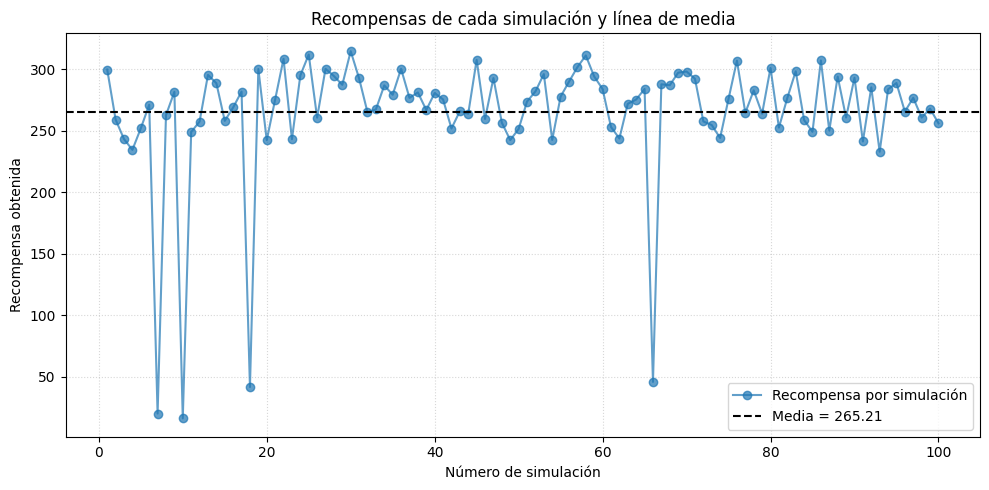

In [24]:
best_chromosome = np.load("best_chromosome13.npy")
print("Evaluating the best chromosome...")
results = evaluate_best_chromosome(best_chromosome)
plot_rewards(results["rewards"])

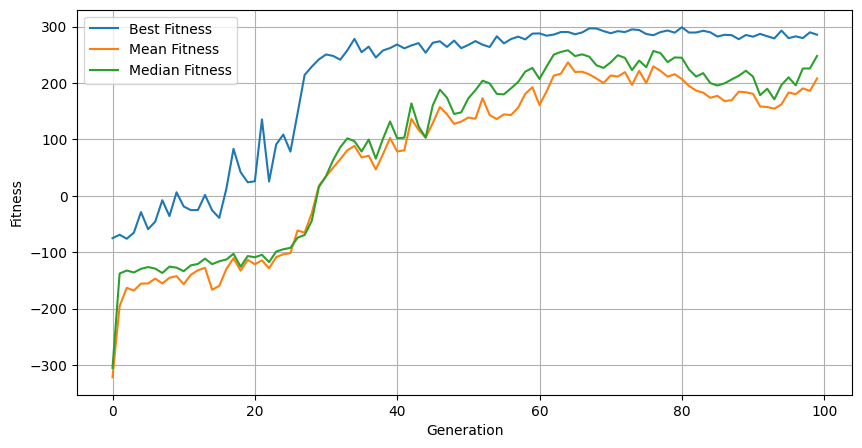

In [25]:
graficas("best13.npy", "mean13.npy", "median13.npy")

# Seleccion por ruleta

In [63]:
# Hyperparameters
population_size = 100
chromosome_size = 8 * 4 + 4  # Weights + Biases
generations = 100
mutation_rate = 0
alpha = 0.7

In [64]:
best_chromosome= genetic_algorithm(14, population_size, chromosome_size, generations, mutation_rate, crossover='blx_alpha', alpha=alpha, selection_method='roulette')

[ 1.03367135 -0.0715296   1.95297104 -2.81132167  1.84829978  0.39370452
 -1.21426501 -2.71982568  2.9437644  -2.9590456   1.61875817  1.48060261
 -0.73536638 -0.03511529  2.57369035 -0.62727573  2.84373778  0.14648829
 -2.43832144  1.87985048 -1.72987929  0.32607471 -1.2463853   1.89685416
  1.9682554  -1.67053577  0.86900821 -2.42891027 -0.53002057 -2.41880843
 -2.13593401 -1.72682295 -0.14006307 -2.53431698 -1.58973731 -2.96068198]
Population Initialized
Generation 1, Best Fitness: -65.42864786904889
Generation 2, Best Fitness: -40.846244830469594
Generation 3, Best Fitness: -98.88685260055715
Generation 4, Best Fitness: -100.17205375746946
Generation 5, Best Fitness: -65.70635373784043
Generation 6, Best Fitness: -97.61383348238033
Generation 7, Best Fitness: -106.61301609688068
Generation 8, Best Fitness: -86.27023936478953
Generation 9, Best Fitness: -111.31937513280954
Generation 10, Best Fitness: -95.41985586529286
Generation 11, Best Fitness: -102.60806562512388
Generation 12,

Evaluating the best chromosome...
Run 1/100 (seed=0): Reward = 61.32493774474051
Run 2/100 (seed=1): Reward = -114.49542615237425
Run 3/100 (seed=2): Reward = -138.54036784801454
Run 4/100 (seed=3): Reward = -149.52723482914456
Run 5/100 (seed=4): Reward = -137.54004633833307
Run 6/100 (seed=5): Reward = -115.80342138365317
Run 7/100 (seed=6): Reward = 40.442961697649906
Run 8/100 (seed=7): Reward = -126.64507727008487
Run 9/100 (seed=8): Reward = -112.84545377748384
Run 10/100 (seed=9): Reward = -135.29196973653512
Run 11/100 (seed=10): Reward = -163.70484186517731
Run 12/100 (seed=11): Reward = -13.2609890389799
Run 13/100 (seed=12): Reward = -68.82202885744238
Run 14/100 (seed=13): Reward = -27.732078663783966
Run 15/100 (seed=14): Reward = -168.36040861414688
Run 16/100 (seed=15): Reward = -143.7475170441795
Run 17/100 (seed=16): Reward = -140.46180719561232
Run 18/100 (seed=17): Reward = -179.98628505066927
Run 19/100 (seed=18): Reward = -153.20725812868145
Run 20/100 (seed=19): R

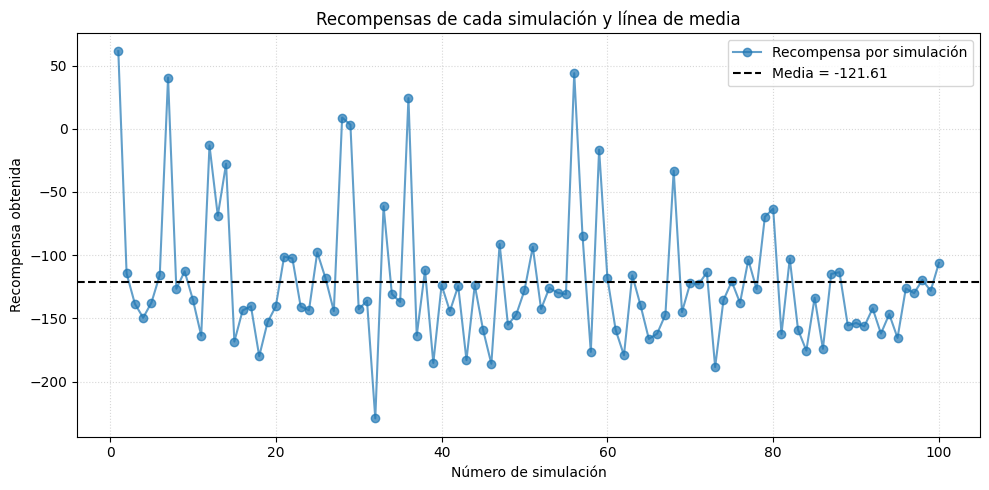

In [65]:
best_chromosome = np.load("best_chromosome14.npy")
print("Evaluating the best chromosome...")
results = evaluate_best_chromosome(best_chromosome)
plot_rewards(results["rewards"])

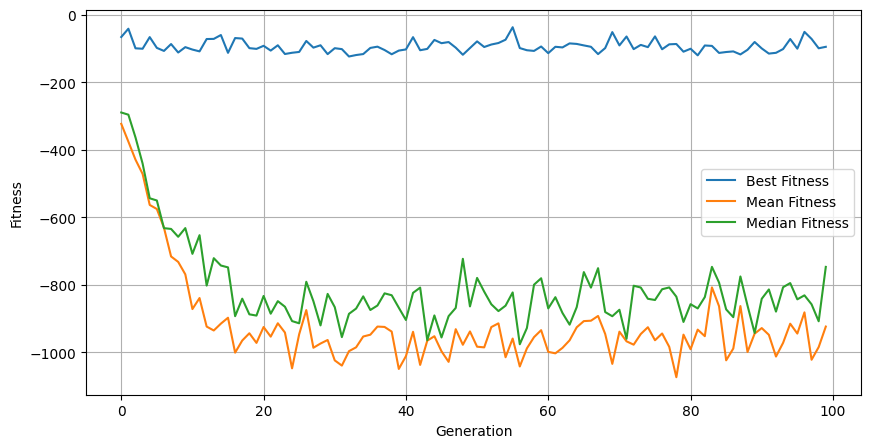

In [66]:
graficas("best14.npy", "mean14.npy", "median14.npy")

In [67]:
best_chromosome= genetic_algorithm(15, population_size, chromosome_size, generations, mutation_rate, crossover='blx_alpha', alpha=alpha, e=30 ,selection_method='roulette')

[ 1.03367135 -0.0715296   1.95297104 -2.81132167  1.84829978  0.39370452
 -1.21426501 -2.71982568  2.9437644  -2.9590456   1.61875817  1.48060261
 -0.73536638 -0.03511529  2.57369035 -0.62727573  2.84373778  0.14648829
 -2.43832144  1.87985048 -1.72987929  0.32607471 -1.2463853   1.89685416
  1.9682554  -1.67053577  0.86900821 -2.42891027 -0.53002057 -2.41880843
 -2.13593401 -1.72682295 -0.14006307 -2.53431698 -1.58973731 -2.96068198]
Population Initialized
Generation 1, Best Fitness: -60.44976885741742
Generation 2, Best Fitness: -65.40389548543871
Generation 3, Best Fitness: -70.19895314894788
Generation 4, Best Fitness: -82.62257513381152
Generation 5, Best Fitness: -82.10933279097337
Generation 6, Best Fitness: -75.8577318382576
Generation 7, Best Fitness: -83.52458404676035
Generation 8, Best Fitness: -58.329398912815485
Generation 9, Best Fitness: -59.11879456316128
Generation 10, Best Fitness: -80.0868134394563
Generation 11, Best Fitness: -89.1481115048081
Generation 12, Best F

Evaluating the best chromosome...
Run 1/100 (seed=0): Reward = -119.4673996109718
Run 2/100 (seed=1): Reward = -40.59220472118888
Run 3/100 (seed=2): Reward = -64.9829491079879
Run 4/100 (seed=3): Reward = -78.67283423715277
Run 5/100 (seed=4): Reward = 22.243334099587216
Run 6/100 (seed=5): Reward = 14.031838329118372
Run 7/100 (seed=6): Reward = -59.38854037959036
Run 8/100 (seed=7): Reward = -39.05937535622914
Run 9/100 (seed=8): Reward = -99.58872503733632
Run 10/100 (seed=9): Reward = -27.154537035858112
Run 11/100 (seed=10): Reward = 233.53630900386213
Run 12/100 (seed=11): Reward = -232.45389883208685
Run 13/100 (seed=12): Reward = -51.06705154037557
Run 14/100 (seed=13): Reward = -36.994620040981346
Run 15/100 (seed=14): Reward = -198.0798100881679
Run 16/100 (seed=15): Reward = -63.79025229452158
Run 17/100 (seed=16): Reward = -110.0649557979178
Run 18/100 (seed=17): Reward = -75.30302986605523
Run 19/100 (seed=18): Reward = -136.39049843178233
Run 20/100 (seed=19): Reward = -

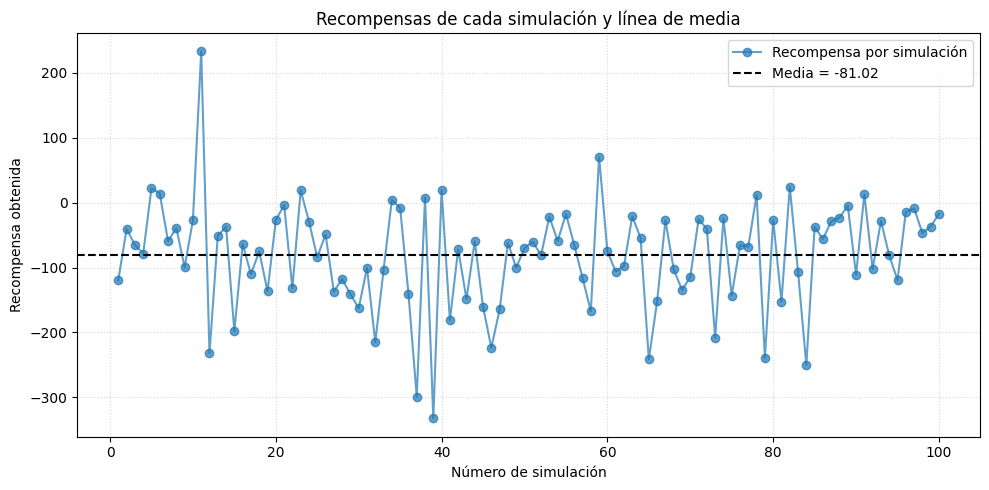

In [68]:
best_chromosome = np.load("best_chromosome15.npy")
print("Evaluating the best chromosome...")
results = evaluate_best_chromosome(best_chromosome)
plot_rewards(results["rewards"])

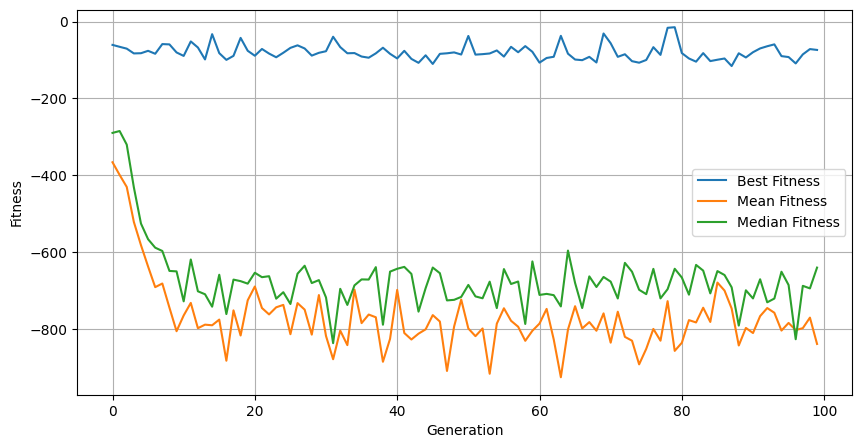

In [69]:
graficas("best15.npy", "mean15.npy", "median15.npy")